 Before you start to solve the exercise, please write your TUM-IDs alongside the names of all group members. This will enable us to assign grades accurately. Thank you.
 
 Member 1: Pham, Doan Xuan Viet; 03698056

 Member 2: Schulz, Julien; 03723706
 
 Member 3: Jehkul, Janik; 03781262

In [1]:
import medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO

In [2]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()

            # TODO: Convert to binary classification
            # check if at least one disease label is present and convert to True/False
            if convert_to_binary:
                targets = torch.where(targets.sum(dim=1) > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device)).long()
                
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()


            loss.backward()
            optimizer.step()
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
    return model

In [3]:
def test(model, data_loader, device, convert_to_binary):
    criterion_ce = nn.CrossEntropyLoss()
    model.eval()
    avg_loss = 0
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()

            # TODO: Convert to binary classification
            if convert_to_binary:
                targets = torch.where(targets.sum(dim=1) > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device)).long()
                
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_preds = torch.max(y_score, dim=1)[1]
        TP = ((y_preds == 1) & (y_true == 1)).sum().item()
        TN = ((y_preds == 0) & (y_true == 0)).sum().item()
        FP = ((y_preds == 1) & (y_true == 0)).sum().item()
        FN = ((y_preds == 0) & (y_true == 1)).sum().item()

        # TODO: Accuracy
        acc = (TP + TN) / (TP + TN + FP + FN)

        # TODO: Positive rate
        positive_rate = TP / (TP + FN)
        print("Positive rate: ", positive_rate)

        # TODO: Negative rate
        negative_rate = TN / (TN + FP)
        print("Negative rate: ", negative_rate)

        # Balanced accuracy
        balanced_acc = (positive_rate + negative_rate) / 2
        print("Balanced accuracy: ", balanced_acc)
        
        print('acc: %.3f \n' % (acc))

# Chest

In [4]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
n_classes_chest = len(info_chest['label'])
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'])

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download)
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# Lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

Using downloaded and verified file: /home/vietp/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/vietp/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/vietp/.medmnist/chestmnist.npz


In [55]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 4, num_classes),
            nn.ReLU()
        )
        
        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        if self.extract_embeddings:
            return x

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 5/5 [00:00<00:00, 93.78it/s]


Epoch: 1	Loss: 0.7110


100%|██████████| 5/5 [00:00<00:00, 92.20it/s]


Epoch: 2	Loss: 0.6075


100%|██████████| 5/5 [00:00<00:00, 87.72it/s]


Epoch: 3	Loss: 0.5380


100%|██████████| 5/5 [00:00<00:00, 89.37it/s]


Epoch: 4	Loss: 0.4723


100%|██████████| 5/5 [00:00<00:00, 90.79it/s]


Epoch: 5	Loss: 0.4227


100%|██████████| 5/5 [00:00<00:00, 87.81it/s]


Epoch: 6	Loss: 0.3726


100%|██████████| 5/5 [00:00<00:00, 89.49it/s]


Epoch: 7	Loss: 0.3250


100%|██████████| 5/5 [00:00<00:00, 95.15it/s]


Epoch: 8	Loss: 0.2874


100%|██████████| 5/5 [00:00<00:00, 82.37it/s]


Epoch: 9	Loss: 0.2437


100%|██████████| 5/5 [00:00<00:00, 79.70it/s]


Epoch: 10	Loss: 0.2062


100%|██████████| 5/5 [00:00<00:00, 91.31it/s]


Epoch: 11	Loss: 0.1792


100%|██████████| 5/5 [00:00<00:00, 90.63it/s]


Epoch: 12	Loss: 0.1515


100%|██████████| 5/5 [00:00<00:00, 88.62it/s]


Epoch: 13	Loss: 0.1261


100%|██████████| 5/5 [00:00<00:00, 93.20it/s]


Epoch: 14	Loss: 0.1130


100%|██████████| 5/5 [00:00<00:00, 86.70it/s]


Epoch: 15	Loss: 0.0977


100%|██████████| 5/5 [00:00<00:00, 90.31it/s]


Epoch: 16	Loss: 0.0804


100%|██████████| 5/5 [00:00<00:00, 85.10it/s]


Epoch: 17	Loss: 0.0745


100%|██████████| 5/5 [00:00<00:00, 87.41it/s]


Epoch: 18	Loss: 0.0630


100%|██████████| 5/5 [00:00<00:00, 89.26it/s]


Epoch: 19	Loss: 0.0590


100%|██████████| 5/5 [00:00<00:00, 89.82it/s]

Epoch: 20	Loss: 0.0501


In [56]:
# Examine the data distribution of the binary classification task. Is accuracy a good metric?
print("Positive in train: " + str(sum(i.sum() > 0 for i in train_dataset_chest.labels)))
print("Negative in train: " + str(sum(i.sum() == 0 for i in train_dataset_chest.labels)) + "\n")
print("Positive in test:  " + str(sum(i.sum() > 0 for i in test_dataset_chest.labels)))
print("Negative in test:  " + str(sum(i.sum() == 0 for i in test_dataset_chest.labels)))

# Positive in train: 134 Negative in train: 166
# Positive in test:  10505 Negative in test:  11928

# Answer in report.

Positive in train: 134
Negative in train: 166

Positive in test:  10505
Negative in test:  11928


In [57]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_chest, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_chest, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
Positive rate:  0.9925373134328358
Negative rate:  1.0
Balanced accuracy:  0.9962686567164178
acc: 0.997 

test
Positive rate:  0.4396953831508805
Negative rate:  0.7075788061703555
Balanced accuracy:  0.573637094660618
acc: 0.582 



## Latent Space

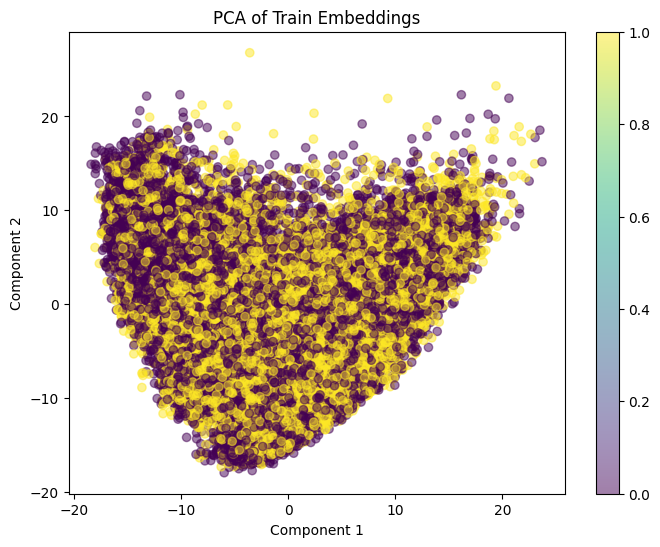

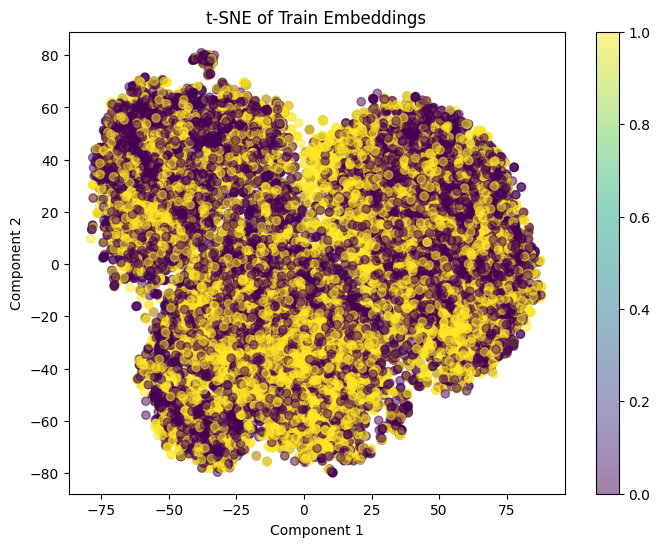

In [58]:
# EXAMINE LATENT SPACE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False
            
            embeddings.append(output)
            labels.append(target)
    
    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_chest)

# TODO: convert labels to binary
test_labels = torch.where(test_labels.sum(dim=1) > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device)).long()


import numpy as np
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE 
t_sne = TSNE(n_components=2)
tsne_result = t_sne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


## Autoencoder

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Define an autoencoder model that is compatable with the previous model. Use dropout with probability p
class Autoencoder(nn.Module):
    def __init__(self, p):
        super().__init__()
        # Encoder
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels_chest, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=p)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=p)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=p)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=p)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=p),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=p),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=p),
            nn.ConvTranspose2d(32, n_channels_chest, kernel_size=3, stride=2, padding=3, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # print(x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.decoder(x)
        return x

# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.05).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0001, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_ae.train()
    for x in train_loader_chest_full:
        inputs, _ = x
        inputs = inputs.to(device)

        # Forward pass
        outputs = model_ae(inputs)
        # print(inputs.shape)
        loss = criterion_ae(outputs, inputs)

        psnr_value = psnr_metric(outputs, inputs)
        ssim_value = ssim_metric(outputs, inputs)

        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

    # Print the metrics for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)
        outputs = model_ae(inputs)

        loss = criterion_ae(outputs, inputs)
        psnr_value_test = psnr_metric(outputs, inputs)
        ssim_value_test = ssim_metric(outputs, inputs)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')


Epoch [1/10], Loss: 0.1714, PSNR: 13.4395, SSIM: 0.1750
Epoch [2/10], Loss: 0.1383, PSNR: 14.3367, SSIM: 0.2870
Epoch [3/10], Loss: 0.1358, PSNR: 14.5182, SSIM: 0.2714
Epoch [4/10], Loss: 0.1298, PSNR: 14.7160, SSIM: 0.3082
Epoch [5/10], Loss: 0.1290, PSNR: 14.5663, SSIM: 0.3352
Epoch [6/10], Loss: 0.1179, PSNR: 14.9575, SSIM: 0.3672
Epoch [7/10], Loss: 0.1362, PSNR: 14.4706, SSIM: 0.3443
Epoch [8/10], Loss: 0.1339, PSNR: 14.4052, SSIM: 0.3363
Epoch [9/10], Loss: 0.1300, PSNR: 14.7774, SSIM: 0.3608
Epoch [10/10], Loss: 0.1327, PSNR: 14.6555, SSIM: 0.3391
Average Test Loss: 0.0020, Average PSNR: 14.8221, Average SSIM: 0.3637


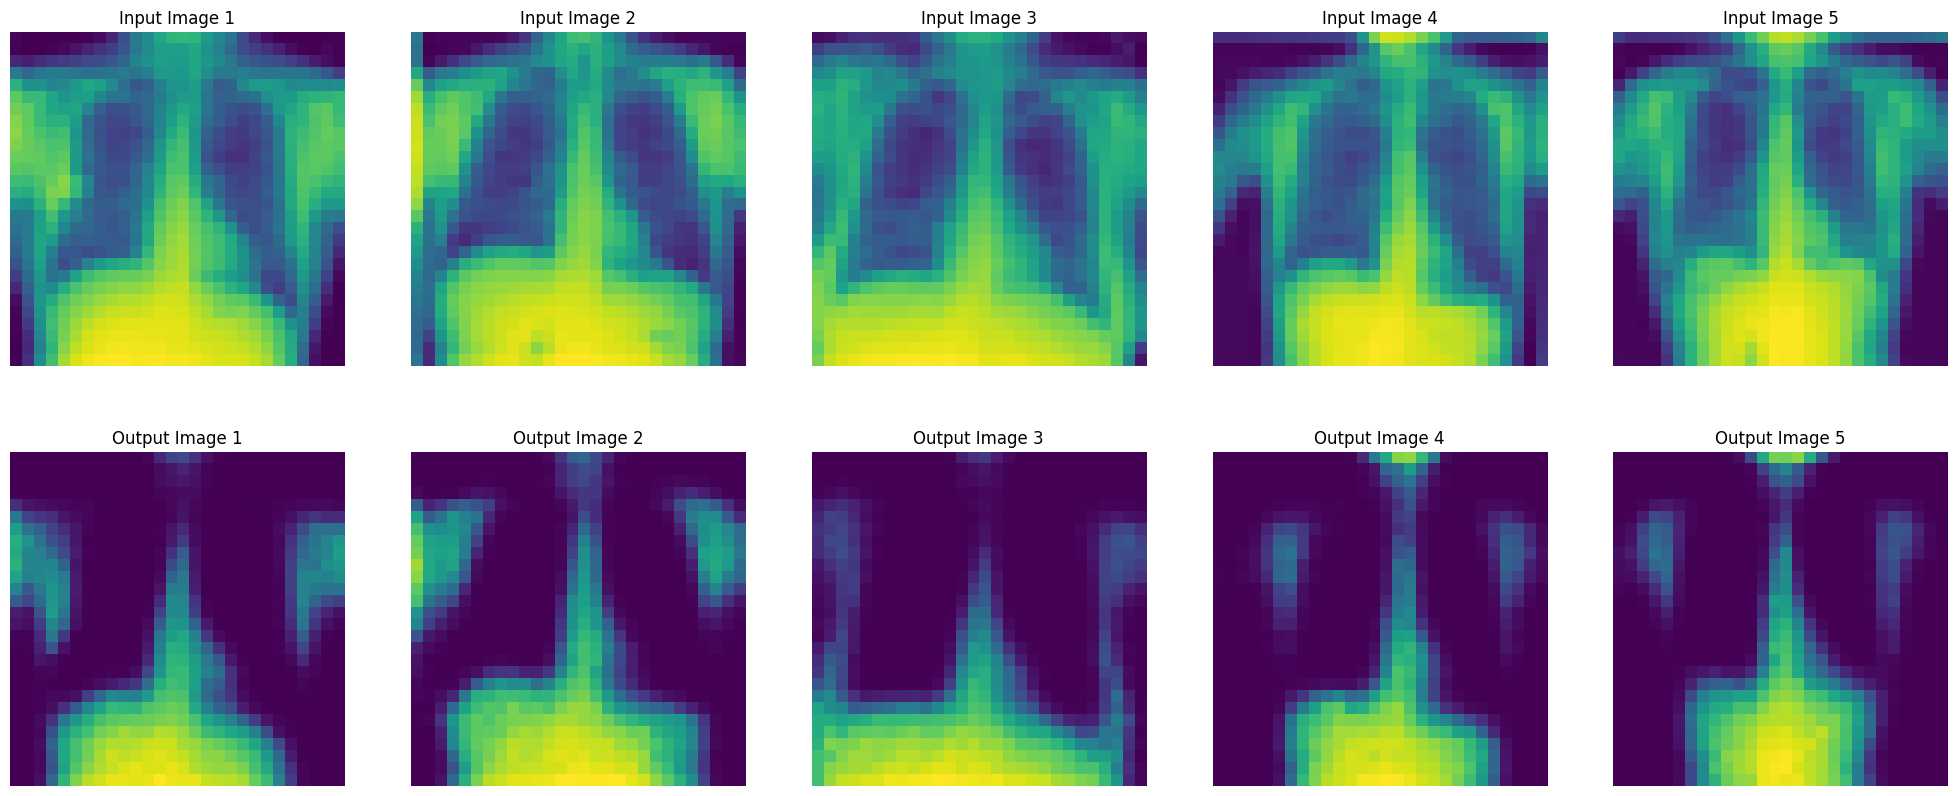

In [60]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_images(model, test_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        test_image_set = next(iter(test_loader))
        inputs, _ = test_image_set
        inputs = inputs.to(device)
        outputs = model(inputs)

        plt.figure(figsize=(5 * num_images, 10))

        for i in range(num_images):
            plt.subplot(2, num_images, i + 1)
            plt.imshow(inputs[i].permute(1, 2, 0).cpu())
            plt.title(f'Input Image {i+1}')
            plt.axis('off')

            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(outputs[i].permute(1, 2, 0).cpu())
            plt.title(f'Output Image {i+1}')
            plt.axis('off')

        plt.show()
# Use the function to plot images
plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [61]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# TODO: Transfer the weights into the new model
model_transfer.state_dict()['layer1.0.weight'] = model_ae.state_dict()['layer1.0.weight']
model_transfer.state_dict()['layer1.0.bias'] = model_ae.state_dict()['layer1.0.bias']
model_transfer.state_dict()['layer1.2.weight'] = model_ae.state_dict()['layer1.2.weight']
model_transfer.state_dict()['layer1.2.bias'] = model_ae.state_dict()['layer1.2.bias']
model_transfer.state_dict()['layer2.0.weight'] = model_ae.state_dict()['layer2.0.weight']
model_transfer.state_dict()['layer2.0.bias'] = model_ae.state_dict()['layer2.0.bias']
model_transfer.state_dict()['layer2.2.weight'] = model_ae.state_dict()['layer2.2.weight']
model_transfer.state_dict()['layer2.2.bias'] = model_ae.state_dict()['layer2.2.bias']
model_transfer.state_dict()['layer3.0.weight'] = model_ae.state_dict()['layer3.0.weight']
model_transfer.state_dict()['layer3.0.bias'] = model_ae.state_dict()['layer3.0.bias']
model_transfer.state_dict()['layer3.2.weight'] = model_ae.state_dict()['layer3.2.weight']
model_transfer.state_dict()['layer3.2.bias'] = model_ae.state_dict()['layer3.2.bias']
model_transfer.state_dict()['layer4.0.weight'] = model_ae.state_dict()['layer4.0.weight']
model_transfer.state_dict()['layer4.0.bias'] = model_ae.state_dict()['layer4.0.bias']
model_transfer.state_dict()['layer4.2.weight'] = model_ae.state_dict()['layer4.2.weight']
model_transfer.state_dict()['layer4.2.bias'] = model_ae.state_dict()['layer4.2.bias']

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=20, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 81.77it/s]


Epoch: 1	Loss: 0.7275


100%|██████████| 5/5 [00:00<00:00, 80.08it/s]


Epoch: 2	Loss: 0.6660


100%|██████████| 5/5 [00:00<00:00, 80.12it/s]


Epoch: 3	Loss: 0.6153


100%|██████████| 5/5 [00:00<00:00, 84.71it/s]


Epoch: 4	Loss: 0.5526


100%|██████████| 5/5 [00:00<00:00, 88.34it/s]


Epoch: 5	Loss: 0.5013


100%|██████████| 5/5 [00:00<00:00, 72.47it/s]


Epoch: 6	Loss: 0.4551


100%|██████████| 5/5 [00:00<00:00, 77.44it/s]


Epoch: 7	Loss: 0.4096


100%|██████████| 5/5 [00:00<00:00, 61.19it/s]


Epoch: 8	Loss: 0.3727


100%|██████████| 5/5 [00:00<00:00, 52.04it/s]


Epoch: 9	Loss: 0.3316


100%|██████████| 5/5 [00:00<00:00, 69.94it/s]


Epoch: 10	Loss: 0.3011


100%|██████████| 5/5 [00:00<00:00, 81.93it/s]


Epoch: 11	Loss: 0.2752


100%|██████████| 5/5 [00:00<00:00, 78.19it/s]


Epoch: 12	Loss: 0.2519


100%|██████████| 5/5 [00:00<00:00, 77.05it/s]


Epoch: 13	Loss: 0.2284


100%|██████████| 5/5 [00:00<00:00, 79.44it/s]


Epoch: 14	Loss: 0.2078


100%|██████████| 5/5 [00:00<00:00, 76.47it/s]


Epoch: 15	Loss: 0.1938


100%|██████████| 5/5 [00:00<00:00, 77.10it/s]


Epoch: 16	Loss: 0.1816


100%|██████████| 5/5 [00:00<00:00, 85.63it/s]


Epoch: 17	Loss: 0.1613


100%|██████████| 5/5 [00:00<00:00, 88.58it/s]


Epoch: 18	Loss: 0.1528


100%|██████████| 5/5 [00:00<00:00, 89.99it/s]


Epoch: 19	Loss: 0.1406


100%|██████████| 5/5 [00:00<00:00, 81.33it/s]

Epoch: 20	Loss: 0.1267


In [63]:
print('==> Evaluating ...')
test(model_transfer, train_loader_chest, device, convert_to_binary=True)
test(model_transfer, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
Positive rate:  0.9626865671641791
Negative rate:  0.9879518072289156
Balanced accuracy:  0.9753191871965474
acc: 0.977 

Positive rate:  0.49043312708234177
Negative rate:  0.6746311200536552
Balanced accuracy:  0.5825321235679985
acc: 0.588 



# Pneumonia

In [115]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

100%|██████████| 4170669/4170669 [00:00<00:00, 12583835.27it/s]

Using downloaded and verified file: /home/vietp/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/vietp/.medmnist/pneumoniamnist.npz


In [116]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [117]:
# train

model_pneumonia = train(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:00<00:00, 79.15it/s]


Epoch: 1	Loss: 0.2700


100%|██████████| 74/74 [00:00<00:00, 81.26it/s]


Epoch: 2	Loss: 0.1210


100%|██████████| 74/74 [00:00<00:00, 80.70it/s]


Epoch: 3	Loss: 0.0913


100%|██████████| 74/74 [00:00<00:00, 80.40it/s]


Epoch: 4	Loss: 0.0725


100%|██████████| 74/74 [00:00<00:00, 78.96it/s]


Epoch: 5	Loss: 0.0569


100%|██████████| 74/74 [00:00<00:00, 80.99it/s]


Epoch: 6	Loss: 0.0474


100%|██████████| 74/74 [00:00<00:00, 80.53it/s]


Epoch: 7	Loss: 0.0404


100%|██████████| 74/74 [00:00<00:00, 84.55it/s]


Epoch: 8	Loss: 0.0323


100%|██████████| 74/74 [00:00<00:00, 83.94it/s]


Epoch: 9	Loss: 0.0262


100%|██████████| 74/74 [00:00<00:00, 85.63it/s]

Epoch: 10	Loss: 0.0213


In [118]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
Positive rate:  0.9994275901545506
Negative rate:  0.9975288303130149
Balanced accuracy:  0.9984782102337828
acc: 0.999 

test
Positive rate:  0.9923076923076923
Negative rate:  0.6196581196581197
Balanced accuracy:  0.805982905982906
acc: 0.853 



## Transfer learning

In [119]:
# For transfer learning lets go back to the full dataset

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 307/307 [00:10<00:00, 29.42it/s]


Epoch: 1	Loss: 0.6560


100%|██████████| 307/307 [00:10<00:00, 28.70it/s]


Epoch: 2	Loss: 0.6332


100%|██████████| 307/307 [00:10<00:00, 29.28it/s]


Epoch: 3	Loss: 0.6248


100%|██████████| 307/307 [00:10<00:00, 28.60it/s]


Epoch: 4	Loss: 0.6187


100%|██████████| 307/307 [00:10<00:00, 29.23it/s]


Epoch: 5	Loss: 0.6131


100%|██████████| 307/307 [00:10<00:00, 27.96it/s]


Epoch: 6	Loss: 0.6081


100%|██████████| 307/307 [00:10<00:00, 28.59it/s]


Epoch: 7	Loss: 0.6031


100%|██████████| 307/307 [00:10<00:00, 28.88it/s]


Epoch: 8	Loss: 0.5981


100%|██████████| 307/307 [00:10<00:00, 28.95it/s]


Epoch: 9	Loss: 0.5937


100%|██████████| 307/307 [00:10<00:00, 29.52it/s]


Epoch: 10	Loss: 0.5893


100%|██████████| 307/307 [00:10<00:00, 28.45it/s]


Epoch: 11	Loss: 0.5847


100%|██████████| 307/307 [00:10<00:00, 28.49it/s]


Epoch: 12	Loss: 0.5792


100%|██████████| 307/307 [00:10<00:00, 28.37it/s]


Epoch: 13	Loss: 0.5738


100%|██████████| 307/307 [00:10<00:00, 28.98it/s]


Epoch: 14	Loss: 0.5688


100%|██████████| 307/307 [00:11<00:00, 27.75it/s]


Epoch: 15	Loss: 0.5639


100%|██████████| 307/307 [00:10<00:00, 28.74it/s]


Epoch: 16	Loss: 0.5584


100%|██████████| 307/307 [00:10<00:00, 28.94it/s]


Epoch: 17	Loss: 0.5534


100%|██████████| 307/307 [00:10<00:00, 28.77it/s]


Epoch: 18	Loss: 0.5477


100%|██████████| 307/307 [00:10<00:00, 28.24it/s]


Epoch: 19	Loss: 0.5414


100%|██████████| 307/307 [00:10<00:00, 27.95it/s]

Epoch: 20	Loss: 0.5359


### Transfer learning - Frozen

In [121]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model
model_pneumonia_transfer_frozen.layer1.load_state_dict(model_chest_full.layer1.state_dict())
model_pneumonia_transfer_frozen.layer2.load_state_dict(model_chest_full.layer2.state_dict())
model_pneumonia_transfer_frozen.layer3.load_state_dict(model_chest_full.layer3.state_dict())
model_pneumonia_transfer_frozen.layer4.load_state_dict(model_chest_full.layer4.state_dict())

# TODO: Freeze all layers except the FC
for name, param in model_pneumonia_transfer_frozen.named_parameters():
    if 'fc' not in name:  # Exclude FC layers
        param.requires_grad = False

#for param in model_pneumonia_transfer_frozen.parameters():
#    param.requires_grad = False
#
#for param in model_pneumonia_transfer_frozen.fc.parameters():
#    param.requires_grad = True

# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

In [122]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:00<00:00, 93.82it/s]


Epoch: 1	Loss: 0.3682


100%|██████████| 74/74 [00:00<00:00, 90.48it/s]


Epoch: 2	Loss: 0.2213


100%|██████████| 74/74 [00:00<00:00, 91.17it/s]


Epoch: 3	Loss: 0.1867


100%|██████████| 74/74 [00:00<00:00, 92.81it/s]


Epoch: 4	Loss: 0.1685


100%|██████████| 74/74 [00:00<00:00, 88.81it/s]


Epoch: 5	Loss: 0.1532


100%|██████████| 74/74 [00:00<00:00, 80.89it/s]


Epoch: 6	Loss: 0.1441


100%|██████████| 74/74 [00:00<00:00, 81.44it/s]


Epoch: 7	Loss: 0.1369


100%|██████████| 74/74 [00:00<00:00, 74.07it/s]


Epoch: 8	Loss: 0.1327


100%|██████████| 74/74 [00:00<00:00, 78.47it/s]


Epoch: 9	Loss: 0.1271


100%|██████████| 74/74 [00:00<00:00, 84.60it/s]

Epoch: 10	Loss: 0.1248


In [123]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
Positive rate:  0.9748139668002289
Negative rate:  0.9019769357495881
Balanced accuracy:  0.9383954512749085
acc: 0.956 

test
Positive rate:  0.9692307692307692
Negative rate:  0.6153846153846154
Balanced accuracy:  0.7923076923076924
acc: 0.837 



In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE
t_sne = TSNE(n_components=2)
tsne_result = t_sne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [ ]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model
model_pneumonia_transfer_trainable.load_state_dict(model_chest_full.state_dict())

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# DONE: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# DONE: Apply t-SNE
t_sne = TSNE(n_components=2)
tsne_result = t_sne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### BONUS: Transfer learning 